In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
from pmlb import fetch_data

X, y = fetch_data('294_satellite_image', return_X_y=True)

In [5]:
X.shape

(6435, 36)

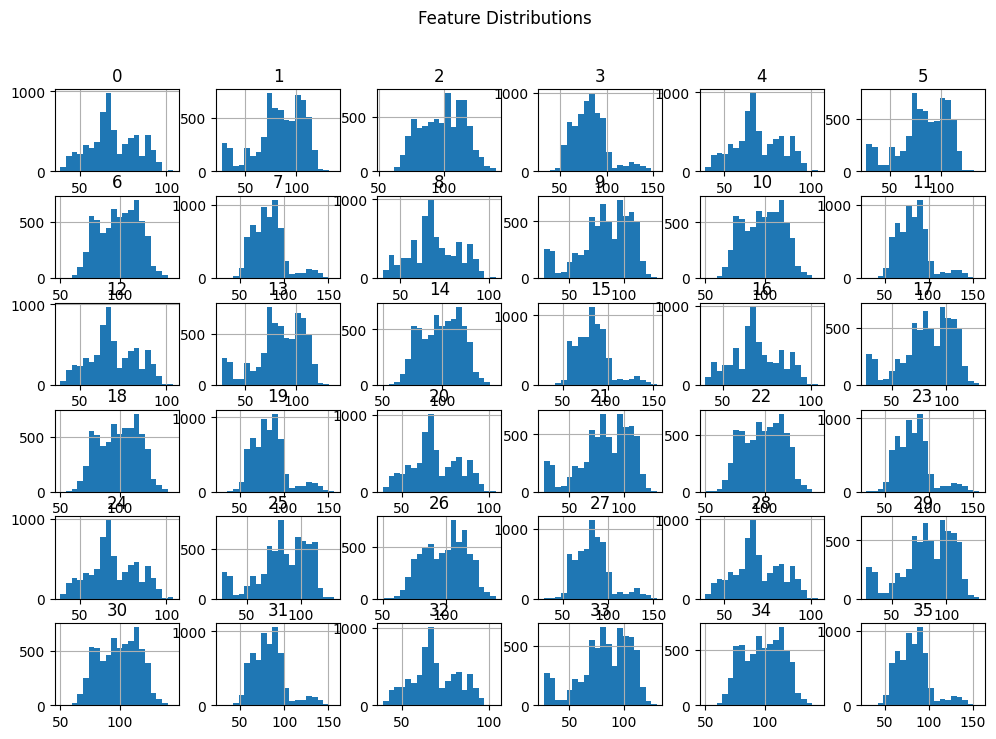

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

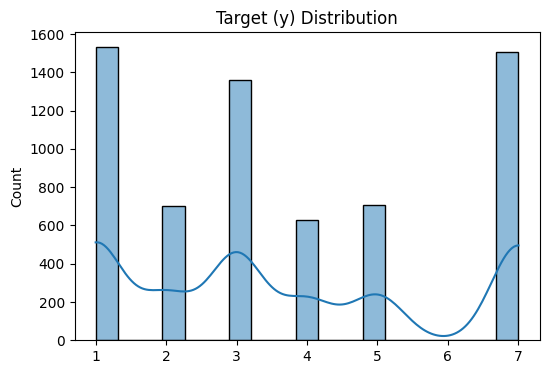

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

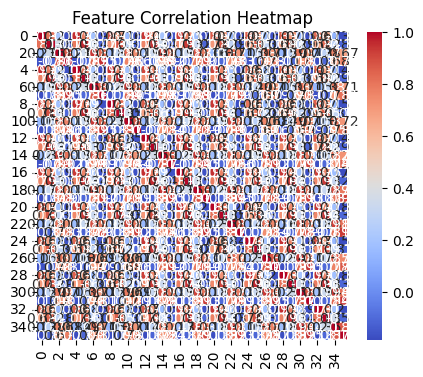

In [8]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.819430                 2.062175             1.852793   
1                  1.774233                 1.760571             1.565089   
2                  1.761190                 1.841734             1.449375   
3                  1.939690                 1.792692             1.657484   
4                  1.909800                 1.756390             1.754928   
mean               1.840869                 1.842712             1.655934   
std                0.080259                 0.127344             0.157698   

      DefaultBART_Rhat_RMSE  
0                  1.665879  
1                  1.655674  
2                  2.106710  
3                  1.617185  
4                  1.315173  
mean               1.672124  
std                0.282669  


In [11]:
rhat_df.to_csv("results/real7_Satellite_rhat.csv", index=False)

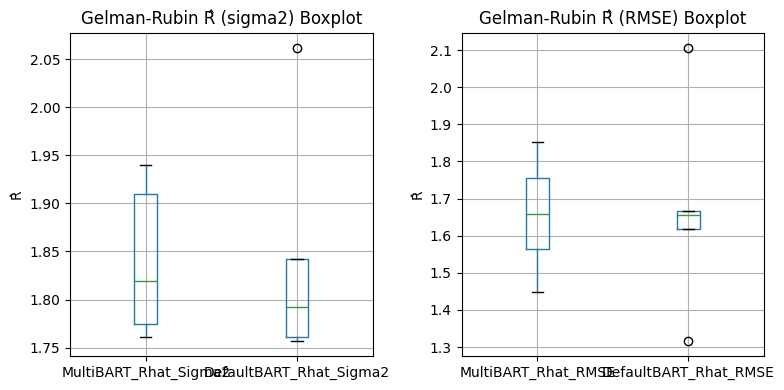

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.603195  0.644438  0.649314  1.018212  0.489757  0.534697
1      0.654345  0.708837  0.754950  0.989041  0.539908  0.580095
2      0.575399  0.621411  0.664071  1.218259  0.483001  0.500649
3      0.640892  0.671587  0.707027  0.981169  0.556418  0.575852
4      0.606375  0.645545  0.677233  1.156214  0.483305  0.504522
5      0.630824  0.682320  0.662476  1.033835  0.503560  0.567139
6      0.634253  0.673496  0.712123  1.005275  0.507003  0.555896
7      0.571869  0.651401  0.664248  1.088002  0.489314  0.524277
8      0.636707  0.691790  0.696441  0.980376  0.519927  0.507214
9      0.663399  0.692839  0.695627  1.066001  0.479440  0.539197
mean   0.621726  0.668366  0.688351  1.053638  0.505163  0.538954
std    0.031346  0.027086  0.031544  0.080093  0.026199  0.029869



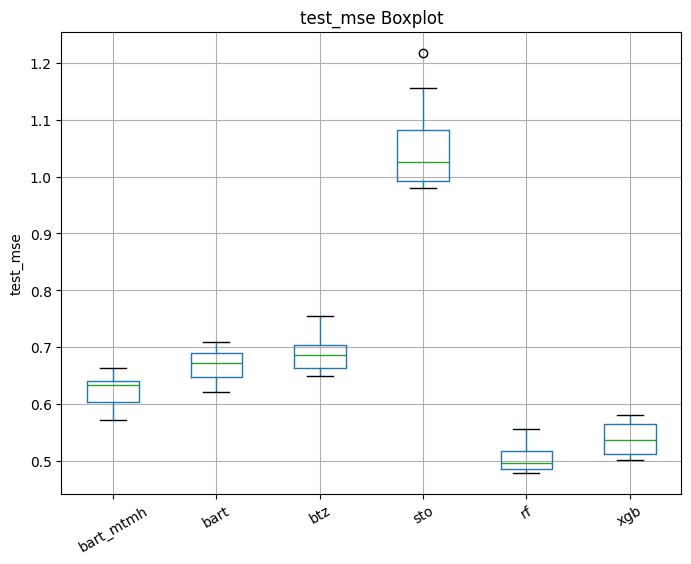

train_mse:
      bart_mtmh      bart       btz       sto        rf       xgb
0      0.287983  0.458978  0.504725  0.918652  0.071356  0.011611
1      0.268861  0.445275  0.489229  0.864780  0.068218  0.011267
2      0.279315  0.491037  0.549149  1.163341  0.071901  0.011581
3      0.275765  0.428284  0.474048  0.954884  0.067736  0.011723
4      0.289545  0.461381  0.522546  1.049172  0.067946  0.010618
5      0.284572  0.482423  0.511182  0.921007  0.069954  0.010860
6      0.287729  0.472686  0.502850  0.897642  0.070489  0.013329
7      0.265396  0.477588  0.495874  0.995674  0.068721  0.012514
8      0.270494  0.486043  0.498837  0.889683  0.070691  0.013440
9      0.275520  0.464841  0.501702  0.987639  0.067813  0.011853
mean   0.278518  0.466854  0.505014  0.964247  0.069483  0.011880
std    0.008691  0.019420  0.020107  0.089636  0.001579  0.000951



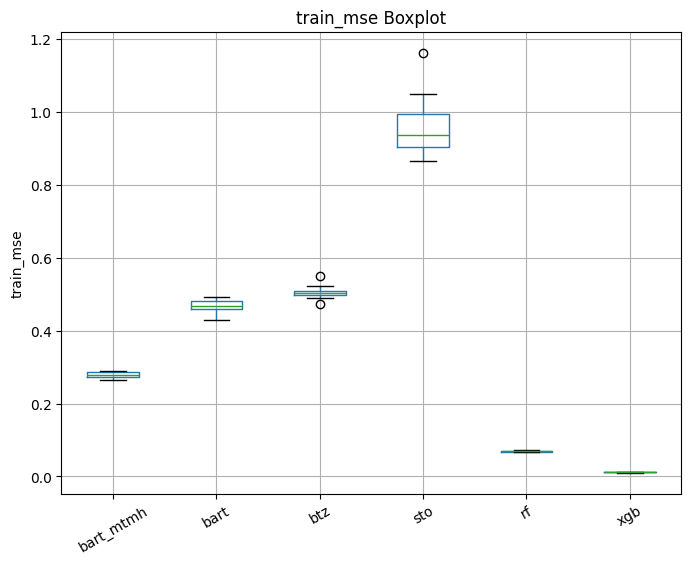

pi_length:
      bart_mtmh      bart       btz          sto
0      2.314694  2.726451  3.170930     8.429710
1      2.257590  2.687874  3.134963    37.083408
2      2.289697  2.818679  3.292961  3778.090324
3      2.240251  2.673209  3.216540    22.992740
4      2.326885  2.742641  3.244646   388.920969
5      2.326151  2.790803  3.239158    75.042040
6      2.320401  2.770809  3.231327    24.091558
7      2.233131  2.763471  3.236480    10.084719
8      2.261892  2.838314  3.210221    19.716755
9      2.262646  2.733094  3.216841    40.346049
mean   2.283334  2.754534  3.219407   440.479827
std    0.036598  0.052958  0.042754  1178.290009



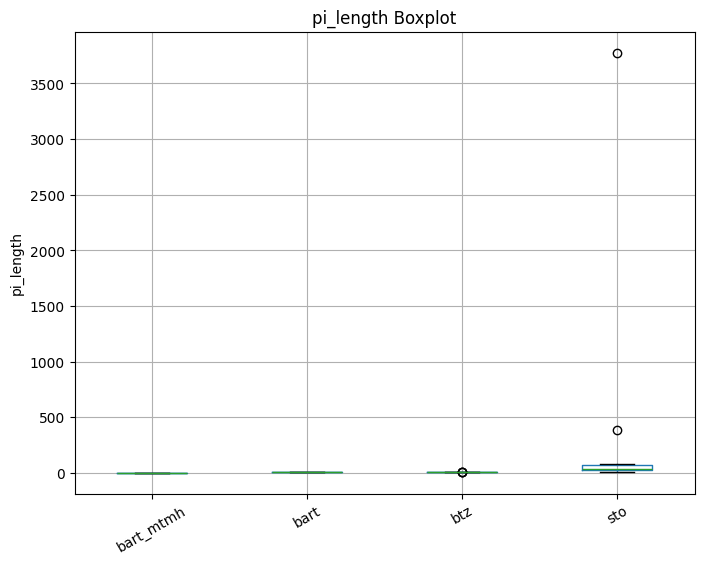

coverage:
      bart_mtmh      bart       btz       sto
0      0.891237  0.901181  0.931013  0.830951
1      0.878807  0.890615  0.912989  0.868863
2      0.876321  0.911746  0.926663  0.886265
3      0.881293  0.899938  0.919204  0.867620
4      0.883779  0.906153  0.923555  0.891858
5      0.880050  0.894966  0.922312  0.868863
6      0.875078  0.885643  0.914854  0.857054
7      0.885022  0.898073  0.925420  0.814792
8      0.873213  0.897452  0.922933  0.868863
9      0.871970  0.893101  0.917340  0.855811
mean   0.879677  0.897887  0.921628  0.861094
std    0.005927  0.007527  0.005562  0.023334



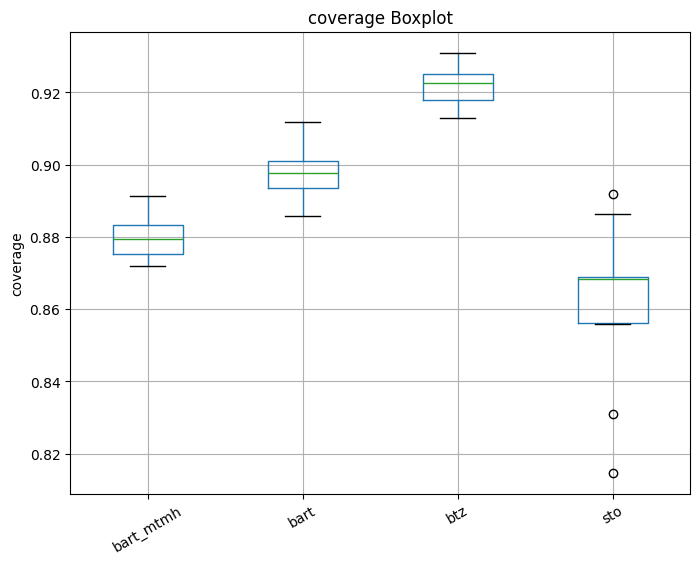

train_time:
      bart_mtmh      bart       btz       sto        rf       xgb
0     20.698098  2.541414  6.288189  5.578876  4.013312  0.254870
1     21.082445  2.577751  6.660435  5.480177  4.000215  0.405199
2     20.970178  2.577315  6.695551  5.418142  4.017601  0.439320
3     21.220130  2.618090  6.948987  5.158420  4.068801  0.323742
4     21.018764  2.542606  6.653133  5.476793  3.928326  0.445908
5     21.771326  2.512738  5.865127  6.223521  3.968100  0.226664
6     22.124654  2.557002  6.431955  5.741586  4.008897  0.223711
7     21.918365  2.600210  6.563260  5.550021  4.144278  0.213038
8     21.860475  2.708572  6.890951  5.193867  4.143554  0.353896
9     22.094399  2.786892  6.914007  5.199965  4.447552  0.306308
mean  21.475883  2.602259  6.591159  5.502137  4.074063  0.319266
std    0.529602  0.084454  0.331113  0.315977  0.148446  0.089666



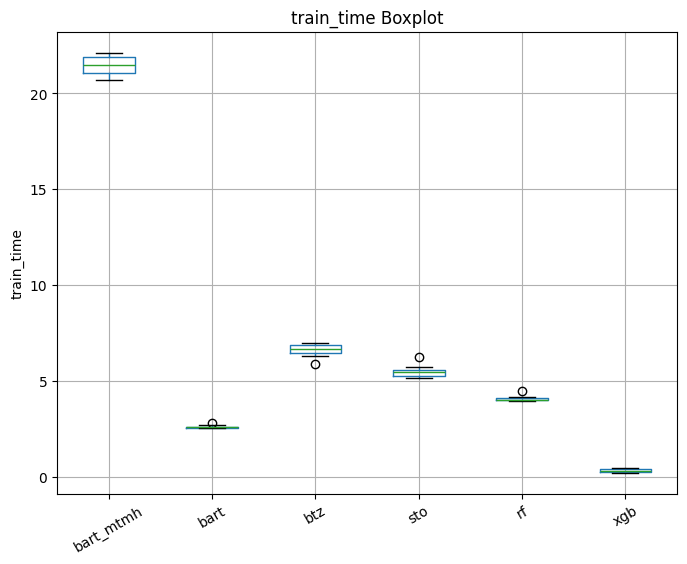

In [13]:
import matplotlib.pyplot as plt

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=100, n_post=100, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [14]:
for k, v in mse_results.items():
    csv_name = f"results/real7_Satellite_{k}.csv"
    v.to_csv(csv_name, index=False)